In [15]:
# pip install rasterio shapely scikit-image torch torchvision matplotlib

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import box

import test
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity


Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe
Torch version: 2.4.1+cu121
CUDA available: True
GPU: NVIDIA GeForce GTX 1660


In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


d:\git\capstone_ipt\venv\Lib\site-packages\matplotlib\colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


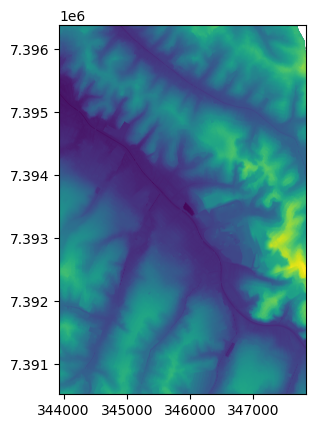

<Axes: >

In [4]:
# from rasterio.plot import show
# data_dir = "dados"
# fp = os.path.join(data_dir, "rec_geosampa.tif")
# reprojected = rasterio.open(fp)
# show(reprojected)
# fp = os.path.join(data_dir, "rec_geosampa_10m.tif")
# reprojected = rasterio.open(fp)
# show(reprojected)
# fp = os.path.join(data_dir, "rec_geosampa_30m.tif")
# reprojected = rasterio.open(fp)
# show(reprojected)

# Recorte de Rasters


In [21]:
import numpy as np
import rasterio
import test
from torch.utils.data import Dataset
from rasterio.windows import Window

class SuperResTiffDataset(Dataset):
    def __init__(self, low_res_files, high_res_files, transform=None):
        # The correct approach is to open each file in a loop and store the datasets.
        self.low_res_datasets = [rasterio.open(f) for f in low_res_files]
        self.high_res_datasets = [rasterio.open(f) for f in high_res_files]
        self.transform = transform # This line is now correct

        # Ensure the number of files is the same.
        assert len(self.low_res_datasets) == len(self.high_res_datasets), "Number of low-res and high-res files must match."

    def __len__(self):
        # Return a large number of "virtual" examples for training.
        # This is a good practice for patch-based datasets to ensure a diverse set of patches
        # are used during each epoch.
        return 10000

    def __getitem__(self, idx):
        # Randomly select a file from the list of datasets for each item.
        # This ensures we are not just iterating through files but drawing random patches from all files.
        file_idx = np.random.randint(0, len(self.low_res_datasets))
        low_res_src = self.low_res_datasets[file_idx]
        high_res_src = self.high_res_datasets[file_idx]

        # Define the window size for cropping. We must check the dimensions of the selected file.
        patch_size = 32
        max_x = low_res_src.width - patch_size
        max_y = low_res_src.height - patch_size

        if max_x < 0 or max_y < 0:
            raise ValueError(f"Image is too small for a {patch_size}x{patch_size} patch.")

        # Randomly select a starting corner for the window.
        random_x = np.random.randint(0, max_x)
        random_y = np.random.randint(0, max_y)
        window = Window(random_x, random_y, patch_size, patch_size)

        # Read the cropped images.
        img_low = low_res_src.read(1, window=window).astype(np.float32)
        img_high = high_res_src.read(1, window=window).astype(np.float32)

        # ... (rest of the normalization and tensor conversion logic) ...

        # Lógica de normalização para img_low
        nodata_low = low_res_src.nodata
        valid_low_mask = img_low != nodata_low if nodata_low is not None else np.ones_like(img_low, dtype=bool)

        if np.any(valid_low_mask):
            min_low = np.min(img_low[valid_low_mask])
            max_low = np.max(img_low[valid_low_mask])
            if max_low - min_low > 0:
                img_low_norm = np.zeros_like(img_low)
                img_low_norm[valid_low_mask] = (img_low[valid_low_mask] - min_low) / (max_low - min_low)
            else:
                img_low_norm = np.zeros_like(img_low)
        else:
            img_low_norm = np.zeros_like(img_low)

        # Lógica de normalização para img_high
        nodata_high = high_res_src.nodata
        valid_high_mask = img_high != nodata_high if nodata_high is not None else np.ones_like(img_high, dtype=bool)

        if np.any(valid_high_mask):
            min_high = np.min(img_high[valid_high_mask])
            max_high = np.max(img_high[valid_high_mask])
            if max_high - min_high > 0:
                img_high_norm = np.zeros_like(img_high)
                img_high_norm[valid_high_mask] = (img_high[valid_high_mask] - min_high) / (max_high - min_high)
            else:
                img_high_norm = np.zeros_like(img_high)
        else:
            img_high_norm = np.zeros_like(img_high)

        # Convert to PyTorch tensors and add a channel dimension.
        low_res_tensor = torch.from_numpy(img_low_norm).unsqueeze(0)
        high_res_tensor = torch.from_numpy(img_high_norm).unsqueeze(0)

        # Apply optional transformations.
        if self.transform:
            low_res_tensor = self.transform(low_res_tensor)
            high_res_tensor = self.transform(high_res_tensor)

        return low_res_tensor, high_res_tensor

    def __del__(self):
        # Ensure all opened files are properly closed.
        for dataset in self.low_res_datasets:
            dataset.close()
        for dataset in self.high_res_datasets:
            dataset.close()

# Arquitetura U-Net


In [22]:
import test
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNetFinal(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_filters=16):
        super().__init__()
        f = base_filters

        self.conv1 = conv_block(in_channels, f)
        self.conv2 = conv_block(f, f*2)
        self.conv3 = conv_block(f*2, f*4)
        self.conv4 = conv_block(f*4, f*8)

        self.pool = nn.MaxPool2d(2, 2)
        self.bottleneck = conv_block(f*8, f*16)

        self.up4 = nn.ConvTranspose2d(f*16, f*8, kernel_size=2, stride=2)
        self.conv_up4 = conv_block(f*16, f*8)

        self.up3 = nn.ConvTranspose2d(f*8, f*4, kernel_size=2, stride=2)
        self.conv_up3 = conv_block(f*8, f*4)

        self.up2 = nn.ConvTranspose2d(f*4, f*2, kernel_size=2, stride=2)
        self.conv_up2 = conv_block(f*4, f*2)

        self.up1 = nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2)
        self.conv_up1 = conv_block(f*2, f)

        self.final_conv = nn.Conv2d(f, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.conv1(x); p1 = self.pool(c1)
        c2 = self.conv2(p1); p2 = self.pool(c2)
        c3 = self.conv3(p2); p3 = self.pool(c3)  # Linha corrigida
        c4 = self.conv4(p3); p4 = self.pool(c4)
        b = self.bottleneck(p4)

        # Decoder (com skip connections)
        u4 = self.up4(b)
        if u4.size() != c4.size():
            u4 = F.interpolate(u4, size=c4.size()[2:], mode='bilinear', align_corners=False)
        u4 = self.conv_up4(torch.cat([u4, c4], 1))

        u3 = self.up3(u4)
        if u3.size() != c3.size():
            u3 = F.interpolate(u3, size=c3.size()[2:], mode='bilinear', align_corners=False)
        u3 = self.conv_up3(torch.cat([u3, c3], 1))

        u2 = self.up2(u3)
        if u2.size() != c2.size():
            u2 = F.interpolate(u2, size=c2.size()[2:], mode='bilinear', align_corners=False)
        u2 = self.conv_up2(torch.cat([u2, c2], 1))

        u1 = self.up1(u2)
        if u1.size() != c1.size():
            u1 = F.interpolate(u1, size=c1.size()[2:], mode='bilinear', align_corners=False)
        u1 = self.conv_up1(torch.cat([u1, c1], 1))

        return self.final_conv(u1)

# Treinamento

In [23]:
# Seus arquivos de entrada
low_res_files = ["dados/rec_anadem.tif"]
high_res_files = ["dados/rec_geosampa.tif"]

dataset = SuperResTiffDataset(low_res_files, high_res_files)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# # Cria o dataset e o loader
# dataset = SuperResTiffDataset(low_res_files, high_res_files)
# loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Instancia o modelo, otimizador e a função de perda
model = UNetFinal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# epochs = 50
epochs = 70
print("Iniciando treinamento...")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for low_res_interp, high_res in loader:
        low_res_interp, high_res = low_res_interp.to(device), high_res.to(device)

        optimizer.zero_grad()
        preds = model(low_res_interp)
        loss = criterion(preds, high_res)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Época [{epoch+1}/{epochs}] | Loss: {epoch_loss:.6f}")

# Salva o modelo treinado
torch.save(model.state_dict(), "unet_superres.pth")
print("✅ Treinamento concluído e modelo salvo.")

Iniciando treinamento...
Época [1/70] | Loss: 522.937673
Época [2/70] | Loss: 235.726962
Época [3/70] | Loss: 82.170001


KeyboardInterrupt: 

# Inferencia


In [ ]:
def gerar_superres_tif_independente(model, low_res_tif, out_path, device, target_size=(256*2, 256*2), scale_factor=60):
    """
    Gera um raster de alta resolução a partir de um raster de baixa resolução usando um modelo treinado.
    Args:
        model: O modelo de rede neural para super-resolução.
        low_res_tif: O caminho para o arquivo TIFF de baixa resolução de entrada.
        out_path: O caminho para salvar o arquivo TIFF de alta resolução gerado.
        device: O dispositivo (CPU ou GPU) onde o modelo será executado.
        target_size: O tamanho das sub-janelas a serem processadas.
        scale_factor: O fator de escala para a super-resolução.
    """
    model.eval()

    with rasterio.open(low_res_tif) as src:
        # Lê os dados de baixa resolução e o perfil
        img_low = src.read(1).astype(np.float32)
        profile = src.profile
        nodata_val = src.nodata

    # Identifica os pixels válidos (ignorando os valores de NoData)
    if nodata_val is not None:
        valid_pixels_mask = img_low != nodata_val
    else:
        valid_pixels_mask = np.ones_like(img_low, dtype=bool)

    # Calcula o mínimo e o máximo APENAS nos pixels válidos
    min_val = np.min(img_low[valid_pixels_mask])
    max_val = np.max(img_low[valid_pixels_mask])

    # Aplica a normalização apenas nos pixels válidos
    img_low_norm = np.zeros_like(img_low)
    if max_val - min_val != 0:
        img_low_norm[valid_pixels_mask] = (img_low[valid_pixels_mask] - min_val) / (max_val - min_val)

    # Cria o tensor de entrada para o modelo
    img_low_tensor = torch.from_numpy(img_low_norm).unsqueeze(0).unsqueeze(0).to(device)

    # Aplica o modelo
    with torch.no_grad():
        output_tensor = model(img_low_tensor)

    # Converte a saída para um array numpy e remove as dimensões extras
    output_array = output_tensor.cpu().numpy().squeeze()

    # Desnormaliza a saída para a escala original dos dados
    output_array = output_array * (max_val - min_val) + min_val

    # Atualiza o perfil para o novo arquivo de alta resolução
    profile.update(
        height=profile['height'] * scale_factor,
        width=profile['width'] * scale_factor,
        transform=profile['transform'] * profile['transform'].scale(1/scale_factor, 1/scale_factor)
    )

    # Salva a imagem de alta resolução
    with rasterio.open(out_path, 'w', **profile) as dst:
        dst.write(output_array, 1)

    print(f"Arquivo gerado com sucesso: {out_path}")

In [ ]:
gerar_superres_tif_independente(model, "rec_anadem_teste.tif", "rec_anadem_teste_UNET.tif", device)

Arquivo gerado com sucesso: rec_anadem_teste_UNET.tif


# Avaliação

In [ ]:
# --- AVALIAÇÃO E PLOTAGEM ---
def avaliar_modelo(model, dataset, device):
    model.eval()
    mse_vals, psnr_vals, ssim_vals = [], [], []

    for low_res_interp, high_res in dataset:
        low_res_interp, high_res = low_res_interp.unsqueeze(0).to(device), high_res.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(low_res_interp).cpu().squeeze().numpy()

        gt = high_res.cpu().squeeze().numpy()

        # As métricas esperam imagens 2D
        gt = np.squeeze(gt)
        pred = np.squeeze(pred)

        mse_vals.append(mean_squared_error(gt, pred))
        psnr_vals.append(peak_signal_noise_ratio(gt, pred, data_range=1))
        ssim_vals.append(structural_similarity(gt, pred, data_range=1))

    return {
        "MSE": np.mean(mse_vals),
        "PSNR": np.mean(psnr_vals),
        "SSIM": np.mean(ssim_vals)
    }

metrics = avaliar_modelo(model, dataset, device)
print("📊 Métricas de Avaliação:", metrics)

In [ ]:
def plotar_rasters(file_list):
    """
    Plota rasters de uma lista de arquivos .tif com o nome no título.
    """
    n = len(file_list)
    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))

    if n == 1:
        axs = [axs]  # garante que axs seja iterável

    for ax, file in zip(axs, file_list):
        with rasterio.open(file) as src:
            show(src, ax=ax, title=os.path.basename(file))

    plt.tight_layout()
    plt.show()


In [ ]:
plotar_rasters([
    "anadem_reprojetado_recortado.tif",
    "geosampa_reprojetado_recortado.tif",
    "novo_recortearicanduva_teste2.tif",
    "saida_final.tif"
])

In [ ]:
def comparar_imagens(ref_path, pred_path):
    """
    Compara imagem de referência com predição do modelo.
    Mostra as imagens lado a lado e imprime métricas (MSE, PSNR, SSIM).
    """
    # Carrega imagens
    with rasterio.open(ref_path) as src:
        ref = src.read(1).astype(np.float32)
    with rasterio.open(pred_path) as src:
        pred = src.read(1).astype(np.float32)

    # Normaliza para [0,1] (necessário para métricas justas)
    ref_norm = (ref - np.min(ref)) / (np.max(ref) - np.min(ref) + 1e-8)
    pred_norm = (pred - np.min(pred)) / (np.max(pred) - np.min(pred) + 1e-8)

    # Calcula métricas
    mse_val = mean_squared_error(ref_norm, pred_norm)
    psnr_val = peak_signal_noise_ratio(ref_norm, pred_norm, data_range=1)
    ssim_val = structural_similarity(ref_norm, pred_norm, data_range=1)

    # Print métricas
    print("📊 Métricas:")
    print(f"   MSE  = {mse_val:.6f}")
    print(f"   PSNR = {psnr_val:.2f} dB")
    print(f"   SSIM = {ssim_val:.4f}")

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(ref, cmap='gray')
    axs[0].set_title("Imagem Referência")
    axs[0].axis("off")

    axs[1].imshow(pred, cmap='gray')
    axs[1].set_title(f"Super-Resolução\nMSE={mse_val:.4f}, PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    return {"MSE": mse_val, "PSNR": psnr_val, "SSIM": ssim_val}


In [ ]:
# comparar_imagens("novo_recortearicanduva_teste2.tif", "saida_final_independente.tif")

# Performance

In [ ]:
def benchmark(model, dataset, device):
    start = time.time()
    metrics = avaliar_modelo(model, dataset, device)
    elapsed = time.time() - start
    print(f"⏱ Tempo de avaliação: {elapsed:.2f}s")
    return metrics, elapsed

results, tempo = benchmark(model, dataset, device)
print("📊 Resultados:", results)


In [ ]:
model = UNetFinal().to(device)
print(model)

Contagem Total
Se somarmos todas as camadas de convolução (Conv2d) e convolução transposta (ConvTranspose2d), que são as camadas "treináveis", o modelo tem:

2 (conv1) + 2 (conv2) + 2 (conv3) + 2 (conv4) = 8 camadas de conv no encoder.

2 (bottleneck) = 2 camadas de conv no gargalo.

1 (up4) + 2 (conv_up4) + 1 (up3) + 2 (conv_up3) + 1 (up2) + 2 (conv_up2) + 1 (up1) + 2 (conv_up1) = 12 camadas no decoder.

1 (final_conv) = 1 camada de conv na saída.

O total é de 8 + 2 + 12 + 1 = 23 camadas de convolução e convolução transposta.

In [ ]:

# # ➡️ 2. Set the path to your .pth file.
# MODEL_PATH = 'unet_superres.pth'

# # ➡️ 3. Check if the file exists.
# if not os.path.exists(MODEL_PATH):
#     print(f"❌ Error: Model file not found at '{MODEL_PATH}'.")
# else:
#     # ➡️ 4. Instantiate the model.
#     # Decide if you want to use a GPU (cuda) or CPU
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = UNet().to(device)

#     # ➡️ 5. Load the state dictionary from the .pth file.
#     try:
#         model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
#         print(f"✅ Model successfully loaded from '{MODEL_PATH}'.")

#         # Now you can use the 'model' object for inference or evaluation.
#         model.eval()
#         # For example, to make a prediction:
#         # dummy_input = torch.randn(1, 3, 256, 256).to(device)
#         # output = model(dummy_input)
#         # print("Model is ready for use.")

#     except Exception as e:
#         print(f"❌ An error occurred while loading the model: {e}")
#         print("This often happens if the model architecture doesn't match the saved weights.")